## Workflow

**Data generation** -> **Data load / Visualization(Plotting)**

## Folder Structure

```
└── pytorch-benchmark
    ├── trace_data
    │   ├── exec_time
    │   │   └── .pickle
    │   └── ncu_reports
    │       └── .ncu-rep
    ├── plots_model_exec.py
    └── plots_test.ipynb
```

# Data generation(without nsight)

In [1]:
!pwd

/workspace/benchmark


In [4]:
import os

MAIN_DIR = os.getcwd()

In [5]:
import torch

print(torch.cuda.is_available())

True


In [3]:
import itertools
from torchbenchmark import list_models

params_test_devices = ('cuda',)#('cpu', 'cuda')
params_test_workloads = ('eval',)#('eval', 'train')
# params_test_models = ('resnet50', 'BERT', 'dlrm', 'nvidia_deeprecommender') # [m.name for m in list_models()]
params_test_models = (
    'BERT_pytorch',
    'alexnet',
    'densenet121',
    'dlrm',
    'drq',
    'fastNLP',
    'nvidia_deeprecommender',
    'pytorch_stargan',
    'pytorch_struct',
    'resnet18',
    'resnet50',
    'resnext50_32x4d',
    'shufflenet_v2_x1_0',
    'soft_actor_critic',
    'squeezenet1_1',
    'timm_efficientnet',
    'timm_nfnet',
    'timm_regnet',
    'timm_resnest',
    'timm_vision_transformer',
    'timm_vovnet',
    'tts_angular',
    'vgg16',
    'yolov3'
)


# params_test[:][0] -> device, params_test[:][1] -> workload, params_test[:][2] -> model
params_test = itertools.product(params_test_devices, params_test_workloads, params_test_models) 


In [4]:
from torchbenchmark import list_models
import torch.autograd.profiler as profiler
import gc


def profile_one_step(func, cuda, niter, nwarmup=3):
    for i in range(nwarmup):
        func() # default niter == 1, for warmup 1 is enough(memory allocation, etc.)

    with profiler.profile(record_shapes=True, use_cuda = cuda) as prof:
        func(niter)

    return prof
    #print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=30))

results = []
torch.set_grad_enabled(False)
for params in params_test:
    device, workload, model = params
    print(model) # debug

    found = False
    for Model in list_models():
        if model.lower() in Model.name.lower():
            found = True
            break

    # build the model and get the task to profile
    m = Model(device = device)
    test = getattr(m, workload)

    prof_data = profile_one_step(test, device == 'cuda', 100)
    gc.collect()
    if device == 'cuda':
        torch.cuda.empty_cache()
    results.append((params, prof_data))


/opt/conda/lib/python3.8/site-packages/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [5]:
from torch.autograd import DeviceType


data_profiledtime_dict = {}
for result in results:
    events = result[1].function_events
    sum_self_cpu_time_total = sum([event.self_cpu_time_total for event in events])

    sum_self_cuda_time_total = 0
    for evt in events:
        if evt.device_type == DeviceType.CPU:
            # in legacy profiler, kernel info is stored in cpu events
            if evt.is_legacy:
                sum_self_cuda_time_total += evt.self_cuda_time_total
        elif evt.device_type == DeviceType.CUDA:
            # in kineto profiler, there're events with the correct device type (e.g. CUDA)
            sum_self_cuda_time_total += evt.self_cuda_time_total

    data_profiledtime_dict[result[0]] = (sum_self_cpu_time_total, sum_self_cuda_time_total)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
for r in results:
    print(f'{", ".join([str(x) for x in r[0]]):<40} {data_profiledtime_dict[r[0]][0]:<20.3f} {data_profiledtime_dict[r[0]][1]:<20.3f}')

cuda, eval, resnet50                     2370782.135          2953959.198         
cuda, eval, BERT                         3790333.371          4931704.641         
cuda, eval, dlrm                         136671.318           133550.442          
cuda, eval, nvidia_deeprecommender       9924123.346          11962347.629        


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd


df = pd.DataFrame()
df['model'] = [r[0][2] for r in results]
df['time_cpu'] = [data_profiledtime_dict[r[0]][0] for r in results]
df['time_cuda'] = [data_profiledtime_dict[r[0]][1] for r in results]

EXPERIMENT_NAME = 'cuda_eval_nograd'

df.to_pickle(os.path.join(MAIN_DIR, 'exec_time', f'{EXPERIMENT_NAME}.pickle')


# Data generation(with nsight)

In [ ]:
# stub

# Data load

In [ ]:
# stub

# Visualization

## code below is just for reference

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


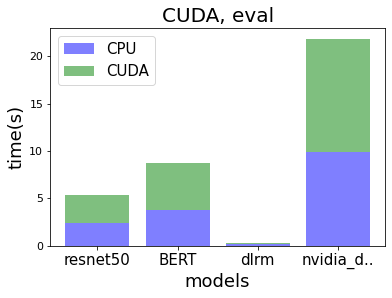

In [8]:
import matplotlib.pyplot as plt

plt_label = [m if len(m)<=8 else m[:8]+'..' for m in params_test_models]
plt_N = len(params_test_models)
plt_index = range(plt_N)
plt_alpha = 0.5

# Temp.
time_div_ratio = 1000*1000
data_cputime_list = [data_profiledtime_dict[('cuda','eval',m)][0]/time_div_ratio for m in params_test_models]
data_cudatime_list = [data_profiledtime_dict[('cuda','eval',m)][1]/time_div_ratio for m in params_test_models]

p1 = plt.bar(plt_index, data_cputime_list, color='b', alpha=plt_alpha)
p2 = plt.bar(plt_index, data_cudatime_list, color='g', alpha=plt_alpha,
             bottom=data_cputime_list) # stacked bar chart
plt.title('CUDA, eval', fontsize=20)
plt.ylabel('time(s)', fontsize=18)
plt.xlabel('models', fontsize=18)
plt.xticks(plt_index, plt_label, fontsize=15)
plt.legend((p1[0], p2[0]), ('CPU', 'CUDA'), fontsize=15)
plt.show()
